In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

In [2]:
df = pd.read_csv('../data/creditcard.csv')

In [3]:
scaler = MinMaxScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

df = df.drop(['Time'], axis=1)

In [4]:
# 'Class' is target variable
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [5]:
print(y_train.value_counts(normalize=True))

Class
0    0.998222
1    0.001778
Name: proportion, dtype: float64


In [6]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

dt_clf = DecisionTreeClassifier(random_state=1, class_weight="balanced")
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)

print(f"Decision Tree - Precision: {precision_score(y_test, y_pred):.2f}, Recall: {recall_score(y_test, y_pred):.2f}, F1-Score: {f1_score(y_test, y_pred):.2f}")

Decision Tree - Precision: 0.74, Recall: 0.74, F1-Score: 0.74


In [7]:
# Decision Tree Classifier Optimization

param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, scoring='recall', n_jobs=-1)
dt_grid_search.fit(X_train, y_train)
best_dt = dt_grid_search.best_estimator_

# Make predictions with the optimized Decision Tree model
y_pred_optimized = best_dt.predict(X_test)

# Calculate and print the performance metrics for the optimized Decision Tree model
print(f"Optimized Decision Tree - Precision: {precision_score(y_test, y_pred_optimized):.2f}, Recall: {recall_score(y_test, y_pred_optimized):.2f}, F1-Score: {f1_score(y_test, y_pred_optimized):.2f}")


Optimized Decision Tree - Precision: 0.93, Recall: 0.71, F1-Score: 0.81


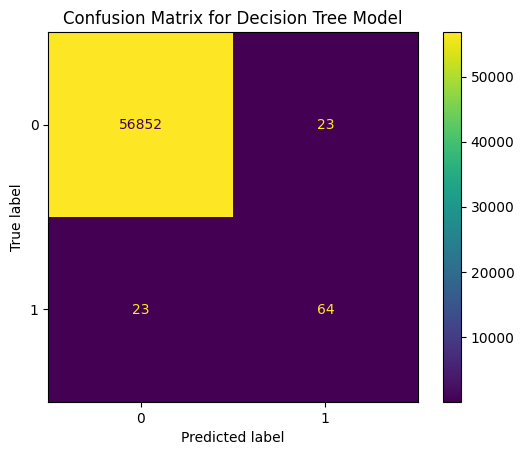

In [8]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for Decision Tree Model')
plt.show()

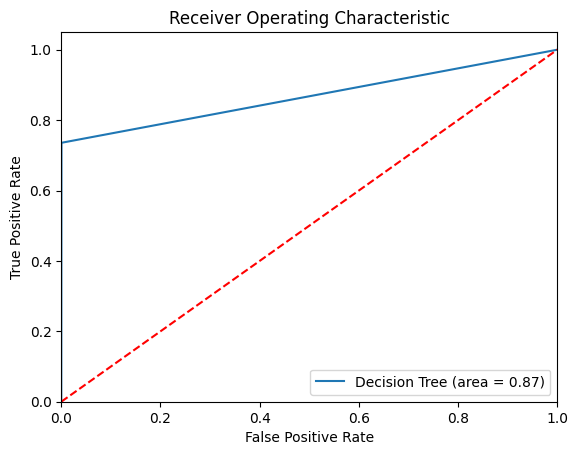

In [9]:


y_pred_proba = dt_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


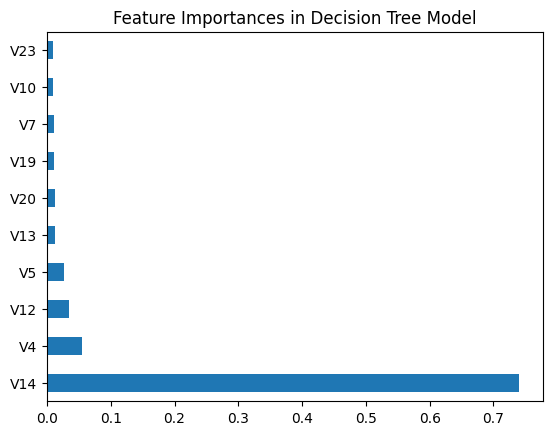

In [10]:
feature_importances = pd.Series(dt_clf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances in Decision Tree Model')
plt.show()

In [11]:
# reduce false negatives, improving on recall,avoid overfitting

new_param_grid = {
    'max_depth': [5, 10, 15], 
    'min_samples_split': [8, 10, 12],  
    'min_samples_leaf': [4, 6, 8], 
    'class_weight': ['balanced'] 
}

# new grid search, recall is scoring metric
new_dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), new_param_grid, cv=5, scoring='recall', n_jobs=-1)
new_dt_grid_search.fit(X_train, y_train)

# get best
new_best_dt = new_dt_grid_search.best_estimator_

# predict with new optimized model
y_pred_new_optimized = new_best_dt.predict(X_test)


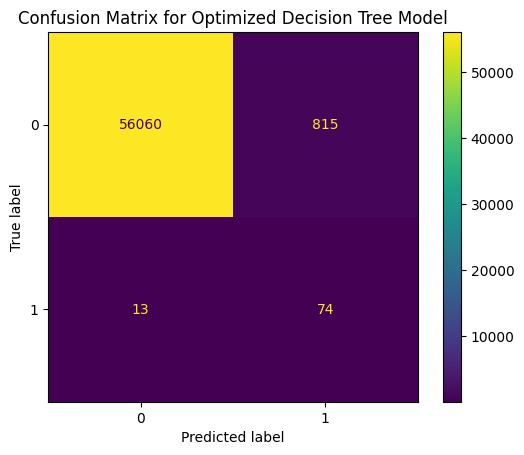

In [12]:
new_cm = confusion_matrix(y_test, y_pred_new_optimized)
new_disp = ConfusionMatrixDisplay(confusion_matrix=new_cm)
new_disp.plot()
plt.title('Confusion Matrix for Optimized Decision Tree Model')
plt.show()


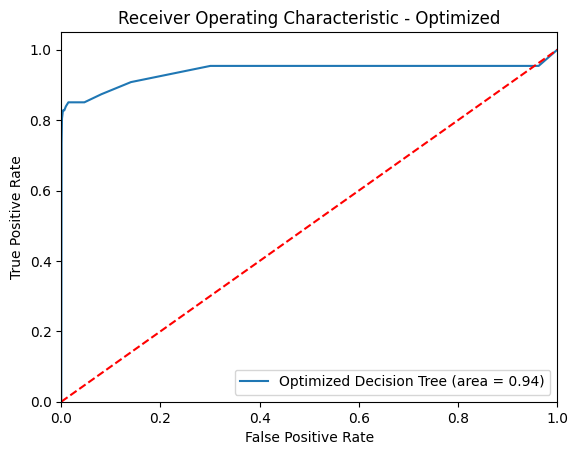

In [13]:
y_pred_proba_optimized = new_best_dt.predict_proba(X_test)[:, 1]
fpr_optimized, tpr_optimized, thresholds_optimized = roc_curve(y_test, y_pred_proba_optimized)
auc_score_optimized = roc_auc_score(y_test, y_pred_proba_optimized)

plt.figure()
plt.plot(fpr_optimized, tpr_optimized, label=f'Optimized Decision Tree (area = {auc_score_optimized:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Optimized')
plt.legend(loc="lower right")
plt.show()

In [14]:


# original model
y_pred_original = dt_clf.predict(X_test)
y_pred_proba_original = dt_clf.predict_proba(X_test)[:, 1]
fpr_original, tpr_original, _ = roc_curve(y_test, y_pred_proba_original)
roc_auc_original = auc(fpr_original, tpr_original)

# optimized model
y_pred_optimized = new_best_dt.predict(X_test)
y_pred_proba_optimized = new_best_dt.predict_proba(X_test)[:, 1]
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_proba_optimized)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# comparison metrics
print("Original vs Optimized Decision Tree Model")
print("------------------------------------------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred_original):.2f} vs {accuracy_score(y_test, y_pred_optimized):.2f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_original):.2f} vs {balanced_accuracy_score(y_test, y_pred_optimized):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_original):.2f} vs {precision_score(y_test, y_pred_optimized):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_original):.2f} vs {recall_score(y_test, y_pred_optimized):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_original):.2f} vs {f1_score(y_test, y_pred_optimized):.2f}")
print(f"ROC AUC: {roc_auc_original:.2f} vs {roc_auc_optimized:.2f}")


Original vs Optimized Decision Tree Model
------------------------------------------------
Accuracy: 1.00 vs 0.99
Balanced Accuracy: 0.87 vs 0.92
Precision: 0.74 vs 0.08
Recall: 0.74 vs 0.85
F1 Score: 0.74 vs 0.15
ROC AUC: 0.87 vs 0.94


In [15]:
from sklearn.metrics import classification_report

# Display the classification report for the original Decision Tree model
print("Classification Report for Original Decision Tree Model:")
print(classification_report(y_test, y_pred_original))

# Display the classification report for the optimized Decision Tree model after the parameter tuning
print("Classification Report for Optimized Decision Tree Model:")
print(classification_report(y_test, y_pred_optimized))

# Display the classification report for the further optimized Decision Tree model after adjusting hyperparameters
print("Classification Report for Further Optimized Decision Tree Model:")
print(classification_report(y_test, y_pred_new_optimized))

# Print comparison of key metrics between the original and optimized models
print("Original vs Optimized Decision Tree Model")
print("------------------------------------------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred_original):.2f} vs {accuracy_score(y_test, y_pred_new_optimized):.2f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_original):.2f} vs {balanced_accuracy_score(y_test, y_pred_new_optimized):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_original):.2f} vs {precision_score(y_test, y_pred_new_optimized):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_original):.2f} vs {recall_score(y_test, y_pred_new_optimized):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_original):.2f} vs {f1_score(y_test, y_pred_new_optimized):.2f}")
print(f"ROC AUC: {roc_auc_original:.2f} vs {roc_auc_optimized:.2f}")


Classification Report for Original Decision Tree Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.74      0.74      0.74        87

    accuracy                           1.00     56962
   macro avg       0.87      0.87      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Classification Report for Optimized Decision Tree Model:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56875
           1       0.08      0.85      0.15        87

    accuracy                           0.99     56962
   macro avg       0.54      0.92      0.57     56962
weighted avg       1.00      0.99      0.99     56962

Classification Report for Further Optimized Decision Tree Model:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56875
           1       0.08      0.85      0.15        87

    

Classification Report for Original Decision Tree Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.74      0.74      0.74        87

    accuracy                           1.00     56962
   macro avg       0.87      0.87      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Classification Report for Optimized Decision Tree Model:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56875
           1       0.08      0.85      0.15        87

    accuracy                           0.99     56962
   macro avg       0.54      0.92      0.57     56962
weighted avg       1.00      0.99      0.99     56962

Classification Report for Further Optimized Decision Tree Model:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56875
           1       0.08      0.85      0.15        87

    accuracy                           0.99     56962
   macro avg       0.54      0.92      0.57     56962
weighted avg       1.00      0.99      0.99     56962

Original vs Optimized Decision Tree Model
------------------------------------------------
Accuracy: 1.00 vs 0.99
Balanced Accuracy: 0.87 vs 0.92
Precision: 0.74 vs 0.08
Recall: 0.74 vs 0.85
F1 Score: 0.74 vs 0.15
ROC AUC: 0.87 vs 0.94